<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-alignment-data" data-toc-modified-id="Load-alignment-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load alignment data</a></span></li><li><span><a href="#Copy-filtered-slide-images-to-new-folder-(FewWordImg)" data-toc-modified-id="Copy-filtered-slide-images-to-new-folder-(FewWordImg)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Copy filtered-slide images to new folder (FewWordImg)</a></span></li><li><span><a href="#Using-docarray-to-construct" data-toc-modified-id="Using-docarray-to-construct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using <code>docarray</code> to construct</a></span></li><li><span><a href="#Baseline-models-construction" data-toc-modified-id="Baseline-models-construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline models construction</a></span></li><li><span><a href="#Training-set-and-Testing-set-spilt" data-toc-modified-id="Training-set-and-Testing-set-spilt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training set and Testing set spilt</a></span></li><li><span><a href="#Model-Implementation(Baseline)" data-toc-modified-id="Model-Implementation(Baseline)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Implementation(Baseline)</a></span><ul class="toc-item"><li><span><a href="#Textual-approach" data-toc-modified-id="Textual-approach-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Textual approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Textual)" data-toc-modified-id="Naive-Bayes-(Textual)-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Naive Bayes (Textual)</a></span></li><li><span><a href="#Evaluation-Textual-Results" data-toc-modified-id="Evaluation-Textual-Results-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Evaluation Textual Results</a></span></li></ul></li><li><span><a href="#Visual-approach" data-toc-modified-id="Visual-approach-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visual approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Visual)" data-toc-modified-id="Naive-Bayes-(Visual)-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Naive Bayes (Visual)</a></span></li><li><span><a href="#Evaluation-Visual-Results" data-toc-modified-id="Evaluation-Visual-Results-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Evaluation Visual Results</a></span></li></ul></li><li><span><a href="#Multi-modal-approach" data-toc-modified-id="Multi-modal-approach-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Multi-modal approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Multi-modal)" data-toc-modified-id="Naive-Bayes-(Multi-modal)-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Naive Bayes (Multi-modal)</a></span></li><li><span><a href="#Evaluation-Multi-modal-Results" data-toc-modified-id="Evaluation-Multi-modal-Results-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Evaluation Multi-modal Results</a></span></li></ul></li></ul></li><li><span><a href="#Aggregate-results" data-toc-modified-id="Aggregate-results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Aggregate results</a></span><ul class="toc-item"><li><span><a href="#Training-learning-curve" data-toc-modified-id="Training-learning-curve-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Training learning curve</a></span></li><li><span><a href="#Evaluation-accuracy-and-latency" data-toc-modified-id="Evaluation-accuracy-and-latency-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Evaluation accuracy and latency</a></span></li></ul></li></ul></div>

In [1]:
from typing import List
from docarray import dataclass, Document, DocumentArray
from docarray.typing import Image, Text, JSON, URI
import ast
import pandas as pd
import os
import numpy as np
import platform
import shutil
import re
import sys
import pickle
from time import perf_counter

is_windows = platform.system().lower() == 'windows'

source_dir = os.getcwd()
# source_dir = os.path.join(source_dir, f"Angebot")
dest_dir = "output"
PPTtoImg_dir = os.path.join(dest_dir, f"PPTtoImg")
fWordImg_dir = os.path.join(dest_dir, f"FewWordImg")
ct_fWordImg_dir = os.path.join(fWordImg_dir, f"CT_FewWordImg")
topshapetype_dir = os.path.join(dest_dir, f"TopShapeTypeImg")
labels_dir = os.path.join(dest_dir, f"LABELS")
checkpoint_path = os.path.join(dest_dir, f"checkpoints")

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
if not os.path.exists(PPTtoImg_dir):
    os.makedirs(PPTtoImg_dir)
if not os.path.exists(fWordImg_dir):
    os.makedirs(fWordImg_dir)
if not os.path.exists(ct_fWordImg_dir):
    os.makedirs(ct_fWordImg_dir)  
if not os.path.exists(topshapetype_dir):
    os.makedirs(topshapetype_dir)
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Load alignment data

In [2]:
def convert_to_list(data):
    return ast.literal_eval(data)
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv('alignment_pptx_list.csv', converters={'shape_type': convert_to_list})
# for Mac OS
if not is_windows:
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('C\\Users\\Kun\\Desktop\\Angebot', source_dir))
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('\\', '/'))

df_da = df_da[~df_da['contents'].isnull()]
df_da.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26468 entries, 0 to 26467
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   26468 non-null  object
 1   page_num    26468 non-null  int64 
 2   shape_type  26468 non-null  object
 3   contents    26468 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [3]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [4]:
df_json = pd.read_json(os.path.join(labels_dir, "backup_23148_4374.json"))
# have done for annotations
df_json = df_json[df_json['annotations'].apply(lambda x: len(x) != 0)]
# annotation results exist
df_json = df_json[df_json['annotations'].apply(lambda x: len(x[0]['result']) != 0)]
# 22348 for 13th slide
count = 13

df_few_words['label'] = ''

for idx, row in enumerate(df_json.iterrows()):
  slide = row[1]
  image_path = slide['data']['image']
  choice = slide['annotations'][0]['result'][0]['value']['choices'][0]
  # print(image_path, choice)
  if image_path.find('22348')!=-1:
    # print(image_path, choice)
    new_image_name = image_path.split('.')[0] + '_' + str(count) + '.PNG'
    slide['data']['image'] = new_image_name
    image_path = new_image_name
    print(image_path)
    count += 1

  # get page number
  if image_path.split('.')[0].split('_')[-1].isdigit():
    page = int(image_path.split('.')[0].split('_')[-1])
  else:
    page = 0

  # given 'Angebot\ktr' as a condition
  ktr = image_path.split('-')[1].split('_')[0]
  ktr = 'Angebot\\'+ ktr
  ktr = re.escape(ktr)

  # some issues that it should modify manually
  if (ktr == '22348' and page == 13):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Initial Situation'
    continue
  elif (ktr == '22348' and page == 14):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Target Situation'
    continue

  df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = choice

df_few_words.info()

C:\Users\Kun\AppData\Local\Temp\ipykernel_5072\246864648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_few_words['label'] = ''


/data/upload/3/30b5074c-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_EVP8fho_13.PNG
/data/upload/3/33344dac-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_iHJAu6y_14.PNG
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
 5   label       23148 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [5]:
df_few_words[df_few_words['label'].isna()]

,file_name,page_num,shape_type,contents,word_count,label


In [6]:
df_few_words['label'].value_counts()

                               18778
Working Package Examples         668
Others                           607
Working Package Description      564
Reference Details                407
Consultant Profile               370
Offer Title                      365
Project Calculation              304
Initial & Target Situation       255
Working Package Overview         237
Reference Overview               215
Competencies                     189
Target Situation                 103
Initial Situation                 86
Name: label, dtype: int64

In [7]:
df_few_words = df_few_words[(df_few_words['label']!='') & (df_few_words['label']!='Others')]

# Copy filtered-slide images to new folder (FewWordImg)

In [ ]:
def delete_png_files(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.lower().endswith(".PNG"):
            os.remove(filepath)

In [7]:
# copy filtered-data to new folder(FewWordImg)
delete_png_files(fWordImg_dir)
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(PPTtoImg_dir)  # image output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        
        # from PPTtoImg to FewWordImg
        shutil.copy(imgpath, os.path.join(os.getcwd(), fWordImg_dir))

> This process is to ignore **Chapter Covers** images so that we make them labeling easier

# Using `docarray` to construct

In [8]:
@dataclass
class MySlide:
    Content: Text #chunk
    ImgPath: Image #chunk
    ShapeType: List[str] #tag
    PageNum: int #tag
    Label: str #tag

@dataclass
class MyPPT:
    FileName: Text
    Slide: List[MySlide]

group_slide = DocumentArray()
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(fWordImg_dir)  # filter-images output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        # imgpath = os.path.join(image_dir_path, )
        
        m = MySlide(
                    Content = row['contents'],
                    ImgPath = imgpath,
                    ShapeType = row['shape_type'],
                    PageNum = row['page_num'],
                    Label = row['label']
                )
        
        group_slide.append(Document(m))
            
docPPT = Document(MyPPT(FileName = path, Slide = group_slide))

In [15]:
docPPT_1620 = Document(MyPPT(FileName=docPPT.FileName, Slide=[d for d in docPPT.Slide if d.tags['Label'] != ''and d.tags['Label'] != 'Others']))

# Baseline models construction

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split, KFold

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# This function will print the metrcis for diffeent model
def print_model_report(y_test, prediction, ML_modelName):
    print("Model report for: "+ ML_modelName + "\n")
    print(classification_report(y_test, prediction, digits=4, target_names=['Competencies[0]', 
                                                                            'Consultant Profile[1]', 
                                                                            'Initial & Target Situation[2]', 
                                                                            'Initial Situation[3]', 
                                                                            'Offer Title[4]', 
                                                                            'Project Calculation[5]', 
                                                                            'Reference Details[6]', 
                                                                            'Reference Overview[7]',
                                                                            'Target Situation[8]',
                                                                            'Working Package Description[9]',
                                                                            'Working Package Examples[10]',
                                                                            'Working Package Overview[11]']))
    # print(classification_report(y_test, prediction, digits=4,))
    
# Show confusion matrix plot
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
              annot=True, 
              annot_kws={'size':18,'weight':'normal'},
              fmt='.20g', 
              cmap=cmap, 
              cbar_kws={'shrink':1},
              linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()
    
    
def stratifiedVD(X_train, y_train, ex_model):
    #StratifiedKFold is a variation of KFold
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train, y_train)
    score_list = []
    for k, (train, test) in enumerate(SKF):

        print(train.shape, test.shape)
        # instantiate the model
        ex_model.fit(X_train.iloc[train], y_train.iloc[train])
        # calculate the score each fold
        score = ex_model.score(X_train.iloc[test], y_train.iloc[test])
        score_list.append(score)

        print(f'Fold: {k+1:2d}, Class dist.: {np.bincount(y_train.iloc[train])}, Acc: {score:.3f}')    

    print(f'\nCV accuracy: {np.mean(score_list):.3f} +/- {np.std(score_list):.3f}')
    

def evaluate_model(X, y, pipline):
    # instantiate the model
    # RSKF = RepeatedStratifiedKFold(n_splits=10, random_state=42, n_repeats=3)
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(pipline, X, y, cv= SKF, scoring='accuracy', n_jobs=-1)
    return scores


def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        # roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average= average , multi_class="ovr")

        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

# Training set and Testing set spilt

In [11]:
# dict_augment = {'ori':docPPT.Slide, 'slide_1620':docPPT_1620.Slide}
dict_augment = {'ori':docPPT.Slide}

In [12]:
# given textual or visual information as X variable and the category as y variable
def get_X_y_set(dict_aug):
    dict_ = dict()
    for str, da in dict_aug.items():
        X_text = da['@.[Content]'].to_dataframe().text
        X_shape = pd.Series([slide.tags['ShapeType'] for slide in da])
        y = pd.Series([slide.tags['Label'] for slide in da])
        print(str, X_text.shape, X_shape.shape, y.shape)
        dict_[str] = pd.DataFrame({'X_text': X_text, 'X_shape': X_shape, 'y': y})
        
    return dict_

dict_X_y = get_X_y_set(dict_augment)

ori (3763,) (3763,) (3763,)


In [13]:
keys = 'ori'
dict_X_y[keys]['y'].value_counts()

Working Package Examples       668
Working Package Description    564
Reference Details              407
Consultant Profile             370
Offer Title                    365
Project Calculation            304
Initial & Target Situation     255
Working Package Overview       237
Reference Overview             215
Competencies                   189
Target Situation               103
Initial Situation               86
Name: y, dtype: int64

In [14]:
df_features = pd.DataFrame.from_dict(dict_X_y[keys])

labelencoder = LabelEncoder()
# df_features['y_encoded'] = labelencoder.fit_transform(dict_X_y[keys]['y'])
df_features['y_encoded'] = labelencoder.fit_transform(df_features['y'])
features = [c for c in df_features.columns.values if c not in ['y', 'y_encoded']]
features

['X_text', 'X_shape']

In [15]:
# Train and Test data splits
X_train, X_test, y_train, y_test = train_test_split(df_features[features], df_features['y_encoded'], test_size=0.1,
                                                    stratify=df_features['y_encoded'], random_state=42, shuffle=True)

In [16]:
df_features['y_encoded'].value_counts()

10    668
9     564
6     407
1     370
4     365
5     304
2     255
11    237
7     215
0     189
8     103
3      86
Name: y_encoded, dtype: int64

# Model Implementation(Baseline)

## Textual approach

In [17]:
# bag of words for chi square
# vectorize_cal = CountVectorizer(max_df= 0.85, min_df=2)
vectorize_cal = CountVectorizer()
sparse_matrix = vectorize_cal.fit_transform(X_train['X_text'], y_train)

df_bow=pd.DataFrame(sparse_matrix.toarray(), columns=vectorize_cal.get_feature_names_out())
# df_bow
k_best_cal = SelectKBest(score_func = chi2, k = 2700)
best_matrix = k_best_cal.fit(df_bow, y_train)

cols = best_matrix.get_support(indices=True)
features_df_new = df_bow.iloc[:,cols]
features_df_new.index = X_train['X_text'].index
features_df_new

,01,01102021,02,03,04,05,08,09,10,100,...,öffentlicher,über,übergabe,übergeordnetes,überschrift,übersicht,übertragung,überwachung,überweisung,überzeugten
765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
764,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1096,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2872,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Naive Bayes (Textual)

In [68]:
pipeline_nb_t = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2))),
                          ('chi', SelectKBest(score_func = chi2, k = 5500)),
                          ('tfidf', TfidfTransformer()),
                          ('model', MultinomialNB())])


model_nb_t = pipeline_nb_t.fit(X_train['X_text'], y_train)


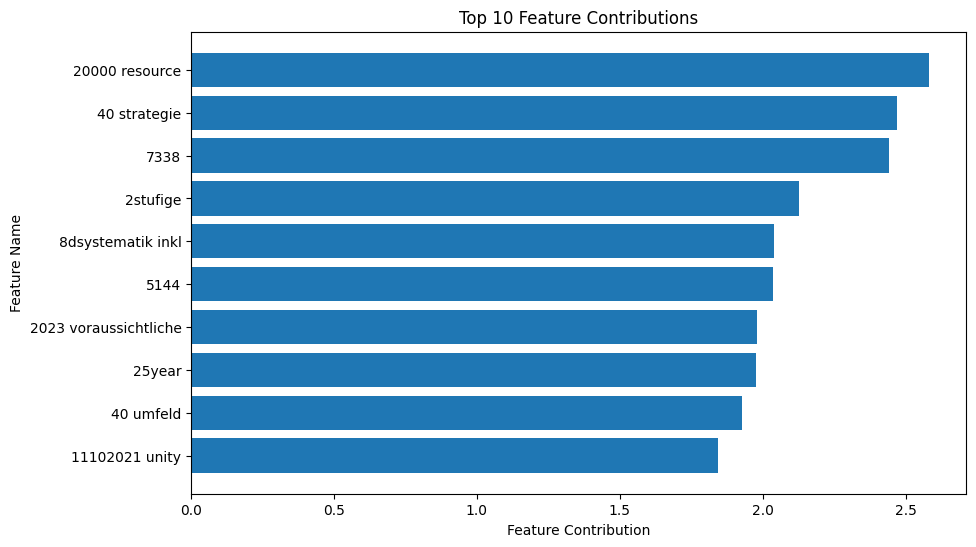

In [69]:
feature_names = pipeline_nb_t.named_steps['vect'].get_feature_names_out()
# 獲取MultinomialNB模型
model = pipeline_nb_t.named_steps['model']

# 獲取各個類別的條件概率
class_conditional_probabilities = model.feature_log_prob_

# 每個特徵的貢獻狀況
feature_contributions = class_conditional_probabilities[1] - class_conditional_probabilities[0]

sorted_features = sorted(zip(feature_contributions, feature_names), reverse=True)

# 擷取排序後的貢獻和特徵名稱，僅保留前十個
top_contributions, top_feature_names = zip(*sorted_features[:10])

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(range(10), top_contributions, align='center')
plt.yticks(range(10), top_feature_names)
plt.xlabel('Feature Contribution')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Contributions')
plt.gca().invert_yaxis()  # 反轉Y軸，以便貢獻最高的特徵在頂部
plt.show()

### Evaluation Textual Results

In [70]:
stratifiedVD(X_train['X_text'], y_train, model_nb_t)

(3047,) (339,)
Fold:  1, Class dist.: [153 300 206  69 295 247 329 175  84 458 540 191], Acc: 0.767
(3047,) (339,)
Fold:  2, Class dist.: [153 300 206  69 295 246 329 175  84 457 541 192], Acc: 0.767
(3047,) (339,)
Fold:  3, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.737
(3047,) (339,)
Fold:  4, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.752
(3047,) (339,)
Fold:  5, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.752
(3047,) (339,)
Fold:  6, Class dist.: [153 300 206  69 295 247 330 174  83 457 541 192], Acc: 0.796
(3048,) (338,)
Fold:  7, Class dist.: [153 300 206  69 295 247 330 175  83 457 541 192], Acc: 0.751
(3048,) (338,)
Fold:  8, Class dist.: [153 299 206  69 296 247 330 175  83 457 541 192], Acc: 0.722
(3048,) (338,)
Fold:  9, Class dist.: [153 299 206  69 296 247 330 175  84 457 541 191], Acc: 0.766
(3048,) (338,)
Fold: 10, Class dist.: [153 299 207  69 295 247 329 175  84 458 541 191], Acc: 0.784


In [71]:
pred_nb_t = model_nb_t.predict(X_test['X_text'])

Model report for: Naive Bayes (Textual)

                                precision    recall  f1-score   support

               Competencies[0]     1.0000    0.8421    0.9143        19
         Consultant Profile[1]     0.8810    1.0000    0.9367        37
 Initial & Target Situation[2]     0.7600    0.7308    0.7451        26
          Initial Situation[3]     1.0000    0.2222    0.3636         9
                Offer Title[4]     1.0000    0.9730    0.9863        37
        Project Calculation[5]     1.0000    0.9333    0.9655        30
          Reference Details[6]     0.9459    0.8537    0.8974        41
         Reference Overview[7]     1.0000    0.5714    0.7273        21
           Target Situation[8]     0.0000    0.0000    0.0000        10
Working Package Description[9]     0.5263    0.8929    0.6623        56
  Working Package Examples[10]     0.7407    0.8955    0.8108        67
  Working Package Overview[11]     1.0000    0.1250    0.2222        24

                     

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


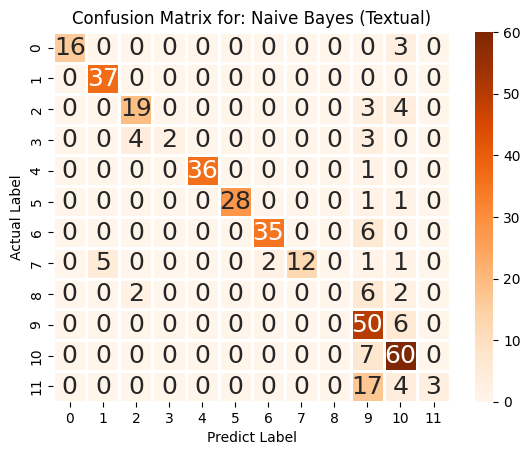

{0: 0.9210526315789473,
 1: 0.9926470588235294,
 2: 0.8568376068376068,
 3: 0.6111111111111112,
 4: 0.9864864864864865,
 5: 0.9666666666666667,
 6: 0.9238530778164924,
 7: 0.7857142857142857,
 8: 0.5,
 9: 0.8763351134846462,
 10: 0.9138902262879153,
 11: 0.5625}

In [72]:
print_model_report(y_test, pred_nb_t, "Naive Bayes (Textual)")
plot_confusion_matrix(y_test, pred_nb_t, "Naive Bayes (Textual)", plt.cm.Oranges)
roc_auc_score_multiclass(y_test, pred_nb_t)

## Visual approach

In [22]:
types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']

mlb = MultiLabelBinarizer(classes=types)
onehot = mlb.fit_transform(X_train['X_shape'])
df_shapes = pd.DataFrame(onehot, columns=mlb.classes_, index=X_train['X_shape'].index)
df_shapes

,AUTO_SHAPE,CALLOUT,CANVAS,CHART,COMMENT,DIAGRAM,EMBEDDED_OLE_OBJECT,FORM_CONTROL,FREEFORM,GROUP,...,MEDIA,OLE_CONTROL_OBJECT,PICTURE,PLACEHOLDER,SCRIPT_ANCHOR,TABLE,TEXT_BOX,TEXT_EFFECT,WEB_VIDEO,MIXED
765,1,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
1761,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1305,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
764,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1096,1,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,0,0,0,0
612,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
2872,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
698,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0


### Naive Bayes (Visual)

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
        self.classes = classes 
        
    def __reduce__(self):
        return (self.__class__, (self.classes,))
    
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, y):
        return self.mlb.transform(y)

pipeline_nb_v = Pipeline([
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
    ('model', MultinomialNB())
])

model_nb_v = pipeline_nb_v.fit(X_train['X_shape'], y_train)

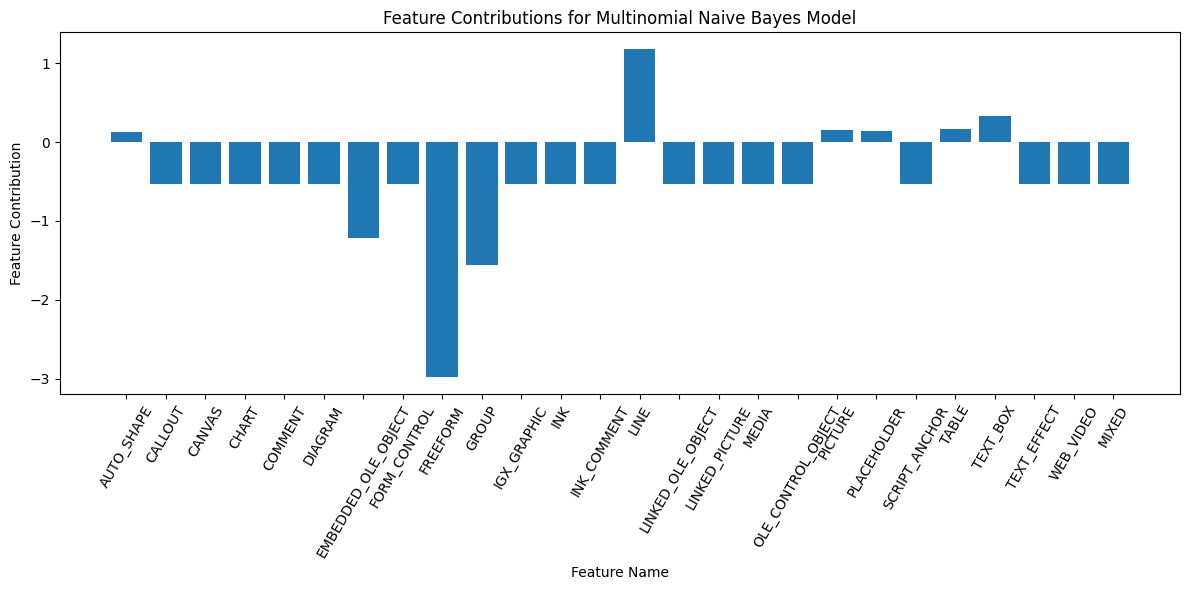

In [46]:
import matplotlib.pyplot as plt

model = model_nb_v.named_steps['model']
feature_log_prob = model.feature_log_prob_  # shape: (n_classes, n_features)
feature_names = model_nb_v.named_steps['mlb_transformer'].mlb.classes_
feature_contributions = feature_log_prob[1] - feature_log_prob[0]
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_contributions)), feature_contributions, align='center')
plt.xticks(range(len(feature_contributions)), feature_names, rotation=60)  # 將 x 軸標籤設定為特徵名稱並旋轉 90 度
plt.xlabel('Feature Name')
plt.ylabel('Feature Contribution')
plt.title('Feature Contributions for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()


In [57]:
feature_log_prob.shape

(12, 26)

<bound method ClassifierMixin.score of MultinomialNB()>
[[-1.8081929  -6.94985646 -6.94985646 -6.94985646 -6.94985646 -6.94985646
  -2.12154272 -6.94985646 -2.2958961  -2.45004678 -6.94985646 -6.94985646
  -6.94985646 -2.87231901 -6.94985646 -6.94985646 -6.94985646 -6.94985646
  -1.84999003 -1.8081929  -6.94985646 -6.94985646 -2.00821403 -6.94985646
  -6.94985646 -6.94985646]
 [-1.68077148 -7.47986413 -7.47986413 -7.47986413 -7.47986413 -7.47986413
  -3.3367294  -7.47986413 -5.28263955 -4.01412823 -7.47986413 -7.47986413
  -7.47986413 -1.68685052 -7.47986413 -7.47986413 -7.47986413 -7.47986413
  -1.69912062 -1.66872314 -7.47986413 -6.78671695 -1.67172164 -7.47986413
  -7.47986413 -7.47986413]
 [-1.91760637 -7.2882444  -7.2882444  -7.2882444  -7.2882444  -7.2882444
  -2.77738489 -7.2882444  -2.03597097 -2.10646085 -7.2882444  -7.2882444
  -7.2882444  -2.07875825 -7.2882444  -7.2882444  -7.2882444  -7.2882444
  -1.90834705 -1.85016509 -7.2882444  -6.59509722 -2.35377047 -7.2882444
  -7.2

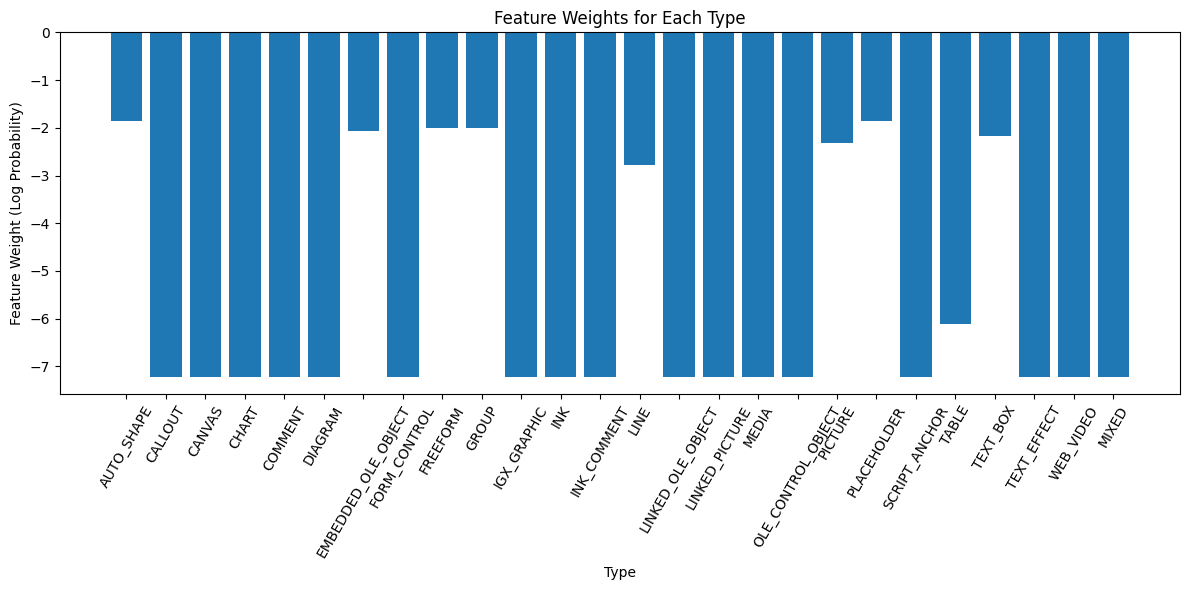

In [62]:
import matplotlib.pyplot as plt

# 獲取 Multinomial Naive Bayes 模型
nb_model = model_nb_v.named_steps['model']
print(nb_model.score)
# 獲取特徵的對數機率
feature_log_prob = nb_model.feature_log_prob_
print(feature_log_prob)
# 轉換為特徵權重
feature_weights = feature_log_prob[11]  # 這裡的1表示正類別，如果有多類別的話，需要調整

# 設置圖表大小
plt.figure(figsize=(12, 6))

# 繪製條形圖
plt.bar(types, feature_weights)
plt.xlabel('Type')
plt.ylabel('Feature Weight (Log Probability)')
plt.title('Feature Weights for Each Type')
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

### Evaluation Visual Results

In [28]:
stratifiedVD(X_train['X_shape'], y_train, model_nb_v)

(3047,) (339,)
Fold:  1, Class dist.: [153 300 206  69 295 247 329 175  84 458 540 191], Acc: 0.605
(3047,) (339,)
Fold:  2, Class dist.: [153 300 206  69 295 246 329 175  84 457 541 192], Acc: 0.655
(3047,) (339,)
Fold:  3, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.628
(3047,) (339,)
Fold:  4, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.602
(3047,) (339,)
Fold:  5, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.602
(3047,) (339,)
Fold:  6, Class dist.: [153 300 206  69 295 247 330 174  83 457 541 192], Acc: 0.602
(3048,) (338,)
Fold:  7, Class dist.: [153 300 206  69 295 247 330 175  83 457 541 192], Acc: 0.598
(3048,) (338,)
Fold:  8, Class dist.: [153 299 206  69 296 247 330 175  83 457 541 192], Acc: 0.577
(3048,) (338,)
Fold:  9, Class dist.: [153 299 206  69 296 247 330 175  84 457 541 191], Acc: 0.636
(3048,) (338,)
Fold: 10, Class dist.: [153 299 207  69 295 247 329 175  84 458 541 191], Acc: 0.589


In [29]:
pred_nb_v = model_nb_v.predict(X_test['X_shape'])

Model report for: Naive Bayes (Visual)

                                precision    recall  f1-score   support

               Competencies[0]     0.0000    0.0000    0.0000        19
         Consultant Profile[1]     0.8966    0.7027    0.7879        37
 Initial & Target Situation[2]     0.7222    0.5000    0.5909        26
          Initial Situation[3]     0.0000    0.0000    0.0000         9
                Offer Title[4]     0.8158    0.8378    0.8267        37
        Project Calculation[5]     0.9310    0.9000    0.9153        30
          Reference Details[6]     0.8293    0.8293    0.8293        41
         Reference Overview[7]     0.0000    0.0000    0.0000        21
           Target Situation[8]     0.0000    0.0000    0.0000        10
Working Package Description[9]     0.5250    0.7500    0.6176        56
  Working Package Examples[10]     0.3662    0.7761    0.4976        67
  Working Package Overview[11]     0.0000    0.0000    0.0000        24

                      

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


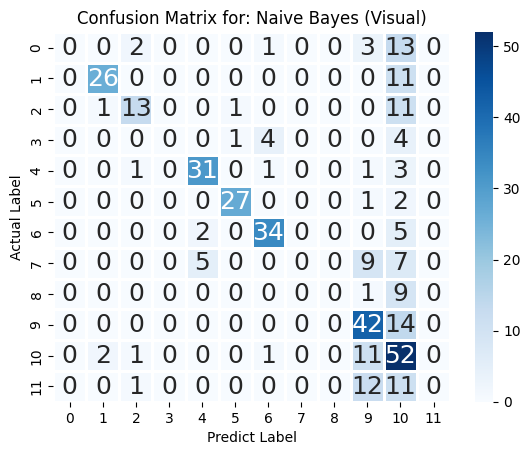

{0: 0.5,
 1: 0.846939586645469,
 2: 0.7428774928774929,
 3: 0.5,
 4: 0.90862480127186,
 5: 0.9471181556195966,
 6: 0.9042174796747967,
 7: 0.5,
 8: 0.5,
 9: 0.815809968847352,
 10: 0.7428984111699567,
 11: 0.5}

In [30]:
print_model_report(y_test, pred_nb_v, "Naive Bayes (Visual)")
plot_confusion_matrix(y_test, pred_nb_v, "Naive Bayes (Visual)", plt.cm.Blues)
roc_auc_score_multiclass(y_test, pred_nb_v)

## Multi-modal approach

### Naive Bayes (Multi-modal)

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin


class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class ShapeSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on shape columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
        self.classes = classes
        
    def __reduce__(self):
        return (self.__class__, (self.classes,))
    
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)    

types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']
    


In [32]:
pipeline_text_sel=Pipeline([('selector', TextSelector(key='X_text')),
                            ('vect', CountVectorizer(ngram_range = (1, 2))),
                            ('chi', SelectKBest(score_func = chi2, k = 2500)),
                            ('tfidf', TfidfTransformer()),
                    ])

text_base = pipeline_text_sel.fit_transform(X_train, y_train)

pipeline_shape_sel=Pipeline([
    ('selector', ShapeSelector(key='X_shape')),
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
])

shape_type = pipeline_shape_sel.fit_transform(X_train, y_train)

In [33]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion([
    ('text', pipeline_text_sel),
    ('shape', pipeline_shape_sel),
])

pipline_feature_processing = Pipeline([('feats', feats)])
feature_processing=pipline_feature_processing.fit_transform(X_train, y_train)

In [34]:
pipeline = Pipeline([
    ('features',feats),
    ('model', MultinomialNB()),
])
model_nb_mm = pipeline.fit(X_train, y_train)

### Evaluation Multi-modal Results

In [35]:
stratifiedVD(X_train, y_train, model_nb_mm)

(3047,) (339,)
Fold:  1, Class dist.: [153 300 206  69 295 247 329 175  84 458 540 191], Acc: 0.773
(3047,) (339,)
Fold:  2, Class dist.: [153 300 206  69 295 246 329 175  84 457 541 192], Acc: 0.779
(3047,) (339,)
Fold:  3, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.752
(3047,) (339,)
Fold:  4, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.746
(3047,) (339,)
Fold:  5, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.773
(3047,) (339,)
Fold:  6, Class dist.: [153 300 206  69 295 247 330 174  83 457 541 192], Acc: 0.814
(3048,) (338,)
Fold:  7, Class dist.: [153 300 206  69 295 247 330 175  83 457 541 192], Acc: 0.769
(3048,) (338,)
Fold:  8, Class dist.: [153 299 206  69 296 247 330 175  83 457 541 192], Acc: 0.722
(3048,) (338,)
Fold:  9, Class dist.: [153 299 206  69 296 247 330 175  84 457 541 191], Acc: 0.796
(3048,) (338,)
Fold: 10, Class dist.: [153 299 207  69 295 247 329 175  84 458 541 191], Acc: 0.784


In [36]:
pred_nb_mm = model_nb_mm.predict(X_test)

Model report for: Naive Bayes (Multi-modal)

                                precision    recall  f1-score   support

               Competencies[0]     1.0000    0.6842    0.8125        19
         Consultant Profile[1]     1.0000    1.0000    1.0000        37
 Initial & Target Situation[2]     0.7273    0.6154    0.6667        26
          Initial Situation[3]     1.0000    0.2222    0.3636         9
                Offer Title[4]     1.0000    0.9730    0.9863        37
        Project Calculation[5]     1.0000    0.9333    0.9655        30
          Reference Details[6]     0.9750    0.9512    0.9630        41
         Reference Overview[7]     1.0000    0.5714    0.7273        21
           Target Situation[8]     1.0000    0.2000    0.3333        10
Working Package Description[9]     0.6933    0.9286    0.7939        56
  Working Package Examples[10]     0.6038    0.9552    0.7399        67
  Working Package Overview[11]     1.0000    0.1667    0.2857        24

                 

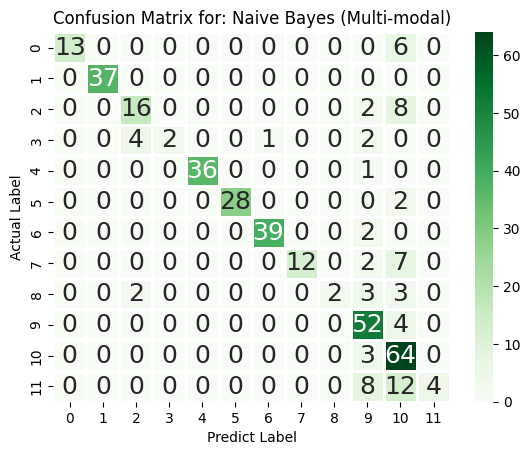

{0: 0.8421052631578947,
 1: 1.0,
 2: 0.7991452991452991,
 3: 0.6111111111111112,
 4: 0.9864864864864865,
 5: 0.9666666666666667,
 6: 0.9741216608594657,
 7: 0.7857142857142857,
 8: 0.6,
 9: 0.9284601691143747,
 10: 0.9098700048146365,
 11: 0.5833333333333334}

In [37]:
print_model_report(y_test, pred_nb_mm, "Naive Bayes (Multi-modal)")
plot_confusion_matrix(y_test, pred_nb_mm, "Naive Bayes (Multi-modal)", plt.cm.Greens)
roc_auc_score_multiclass(y_test, pred_nb_mm)

# Aggregate results

[0] Competencies: 19
[1] Consultant Profile: 37
[2] Initial & Target Situation: 26
[3] Initial Situation: 9
[4] Offer Title: 37
[5] Project Calculation: 30
[6] Reference Details: 41
[7] Reference Overview: 21
[8] Target Situation: 10
[9] Working Package Description: 56
[10] Working Package Examples: 67
[11] Working Package Overview: 24


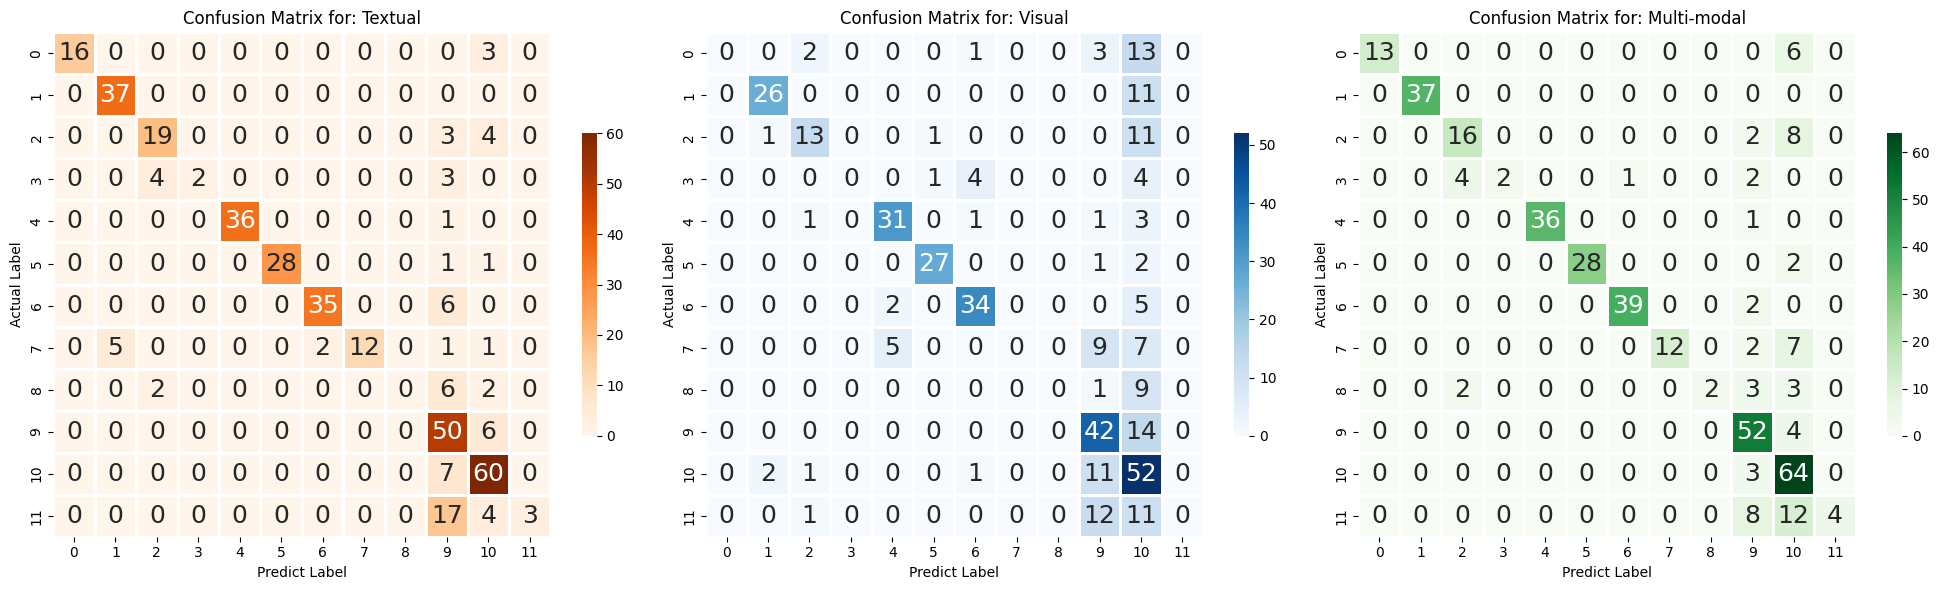

In [73]:
def plot_confusion_matrices(y_test, predictions, model_names, cmap):
    combined_cm = []
    for i, prediction in enumerate(predictions):
        cm = confusion_matrix(y_test, prediction)
        combined_cm.append(cm)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

    for i, ax in enumerate(axs.flat):
        sns.heatmap(combined_cm[i], 
                    annot=True, 
                    annot_kws={'size':18,'weight':'normal'},
                    fmt='.20g', 
                    cmap=cmap[i], 
                    cbar_kws={'shrink':0.6},
                    linewidths=2,
                    ax=ax)
        ax.set_title("Confusion Matrix for: " + model_names[i])
        ax.set_ylabel("Actual Label")
        ax.set_xlabel("Predict Label")
    fig.tight_layout()
    plt.show()


models = ["Textual", "Visual", "Multi-modal"]
preds = [pred_nb_t, pred_nb_v, pred_nb_mm]
colors = [plt.cm.Oranges, plt.cm.Blues, plt.cm.Greens]

labels_name = ['Competencies', 
               'Consultant Profile', 
               'Initial & Target Situation', 
               'Initial Situation', 
               'Offer Title', 
               'Project Calculation', 
               'Reference Details', 
               'Reference Overview',
               'Target Situation',
               'Working Package Description',
               'Working Package Examples',
               'Working Package Overview']

for i, label in enumerate(labels_name):
    num = y_test.value_counts().sort_index()
    print(f"[{i}] {label}: {num[i]}")

plot_confusion_matrices(y_test, preds, models, colors)

> Confusion Matrix for three approach types (Textual, Visual, Multi-Modal) reveals suboptimal model performance due to imbalanced testing data in the following categories: **Competencies[0]**, **Initial & Target Situation[2]**, **Initial Situation[3]**, **Reference Overview[7]**, **Target Situation[8]**, **Working Package Overview[11]**. To address this issue, we should adjust the distribution of label data and retrain the model.

> Imbalance may affect model exhibit a bias towards predicting class more frequently, it has more examples to learn from majority labels and may struggle to accurately capture the patterns in other minor labels.

## Training learning curve

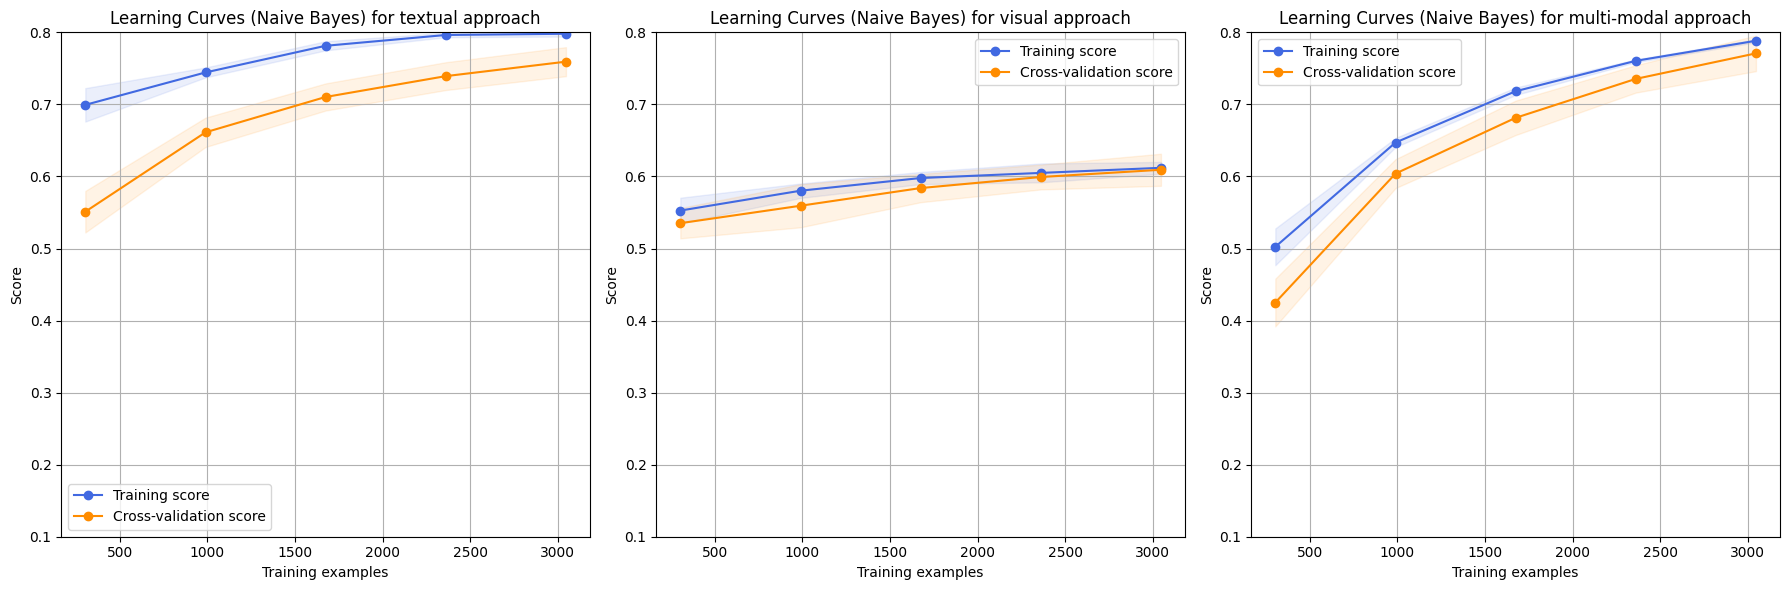

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), ax=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    
    train_sizes : array-like, shape (n_ticks,), optional
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If None, uses np.linspace(0.1, 1.0, 5).

    ax : matplotlib axes, optional
        Axes to plot the learning curve on.
    """
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="royalblue")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="darkorange")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="royalblue",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="darkorange",
             label="Cross-validation score")

    ax.legend(loc="best")


SKF_t = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train['X_text'], y_train)
SKF_v = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train['X_shape'], y_train)
SKF_mm = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train, y_train)


fig, axes = plt.subplots(1, 3, figsize=(18, 6))


plot_learning_curve(model_nb_t, "Learning Curves (Naive Bayes) for textual approach", X_train['X_text'], y_train, ylim=(0.1, 0.8), cv=SKF_t, n_jobs=8, ax=axes[0])
plot_learning_curve(model_nb_v, "Learning Curves (Naive Bayes) for visual approach", X_train['X_shape'], y_train, ylim=(0.1, 0.8), cv=SKF_v, n_jobs=8, ax=axes[1])
plot_learning_curve(model_nb_mm, "Learning Curves (Naive Bayes) for multi-modal approach", X_train, y_train, ylim=(0.1, 0.8), cv=SKF_mm, n_jobs=8, ax=axes[2])


plt.tight_layout()


plt.show()


## Evaluation accuracy and latency

In [135]:
class PerformanceBaselineBase:
    def __init__(self, model, X_testset, y_testset, optim_type):
        self.model = model
        self.X_testset = X_testset
        self.y_testset = y_testset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # Define this in the subclasses
        pass

    def compute_size(self):
        # Define this in the subclasses
        pass

    def time_pipeline(self):
        # Define this in the subclasses
        pass

    def run(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

class TextPerformanceBaseline(PerformanceBaselineBase):
    
    def __init__(self, model, X_testset, y_testset, optim_type):
        super().__init__(model, X_testset, y_testset, optim_type)
        
    def compute_accuracy(self):
        pred = self.model.predict(self.X_testset)
        accuracy = accuracy_score(self.y_testset, pred)
        print(f"Accuracy on test set - {accuracy:.3f}")
        return {"accuracy": accuracy}
    
    def compute_size(self):
        p = pickle.dumps(self.model)
        model_size_bytes = sys.getsizeof(p)
        model_size_mb = model_size_bytes / (1024 * 1024)
        print(f"Model size (MB) - {model_size_mb:.2f}")
        return {"size_mb": model_size_mb}
    
    def time_pipeline(self, query="Best Practice Leistungsgegenstand UNITY Ergebnisbeispiele  Prozessabsicherung Connect  EMobility Teststrategie für Mobile Online Dienste Testfälle in Atlassian Jira CICD Pipeline und DevOps Beispiel"):
        model = self.model
        # Implementation for text method
        latencies = []
        # Warmup
        for _ in range(10):
            _ = model.predict([query])

        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = model.predict([query])
            latency = perf_counter() - start_time
            latencies.append(latency)

        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)

        print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")

        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    
class ImagePerformanceBaseline(PerformanceBaselineBase):
    
    def __init__(self, model, X_testset, y_testset, optim_type):
        super().__init__(model, X_testset, y_testset, optim_type)
    
    def compute_accuracy(self):
        pred = self.model.predict(self.X_testset)
        accuracy = accuracy_score(self.y_testset, pred)
        print(f"Accuracy on test set - {accuracy:.3f}")
        return {"accuracy": accuracy}
    
    def compute_size(self):
        p = pickle.dumps(self.model)
        model_size_bytes = sys.getsizeof(p)
        model_size_mb = model_size_bytes / (1024 * 1024)
        print(f"Model size (MB) - {model_size_mb:.2f}")
        return {"size_mb": model_size_mb}
    
    def time_pipeline(self, query=['PICTURE', 'PLACEHOLDER', 'AUTO_SHAPE', 'GROUP']):
        model = self.model
        # Implementation for text method
        latencies = []
        # Warmup
        for _ in range(10):
            _ = model.predict([query])

        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = model.predict([query])
            latency = perf_counter() - start_time
            latencies.append(latency)

        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)

        print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")

        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    
class MultimodalPerformanceBaseline(PerformanceBaselineBase):
    
    def __init__(self, model, X_testset, y_testset, optim_type):
        super().__init__(model, X_testset, y_testset, optim_type)
        
    def compute_accuracy(self):
        pred = self.model.predict(self.X_testset)
        accuracy = accuracy_score(self.y_testset, pred)
        print(f"Accuracy on test set - {accuracy:.3f}")
        return {"accuracy": accuracy} 
    
    def compute_size(self):
        p = pickle.dumps(self.model)
        model_size_bytes = sys.getsizeof(p)
        model_size_mb = model_size_bytes / (1024 * 1024)
        print(f"Model size (MB) - {model_size_mb:.2f}")
        return {"size_mb": model_size_mb}
    
    def time_pipeline(self, query=None):
        data = [['Best Practice Leistungsgegenstand UNITY Ergebnisbeispiele  Prozessabsicherung Connect  EMobility Teststrategie für Mobile Online Dienste Testfälle in Atlassian Jira CICD Pipeline und DevOps Beispiel', 
         ['PICTURE', 'PLACEHOLDER', 'AUTO_SHAPE', 'GROUP']]]
        columns = ['X_text', 'X_shape']
        query = pd.DataFrame(data, columns = columns)
        
        model = self.model
        
        # Implementation for text method
        latencies = []
        # Warmup
        for _ in range(10):
            _ = model.predict(query)

        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = model.predict(query)
            latency = perf_counter() - start_time
            latencies.append(latency)

        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)

        print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")

        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    
pb = MultimodalPerformanceBaseline(model_nb_v, X_test['X_shape'], y_test, 'NB_v')
perf_metrics = pb.run()

Model size (MB) - 0.01
Average latency (ms) - 0.56 +/- 0.20
Accuracy on test set - 0.597


C:\Users\Kun\miniconda3\envs\unity39\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['X', '_', 'a', 'e', 'h', 'p', 's', 't', 'x'] will be ignored
  warnings.warn(
C:\Users\Kun\miniconda3\envs\unity39\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['X', '_', 'a', 'e', 'h', 'p', 's', 't', 'x'] will be ignored
  warnings.warn(
C:\Users\Kun\miniconda3\envs\unity39\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['X', '_', 'a', 'e', 'h', 'p', 's', 't', 'x'] will be ignored
  warnings.warn(
C:\Users\Kun\miniconda3\envs\unity39\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['X', '_', 'a', 'e', 'h', 'p', 's', 't', 'x'] will be ignored
  warnings.warn(
C:\Users\Kun\miniconda3\envs\unity39\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['X', '_', 'a', 'e', 'h', 'p', 's', 't', 'x'] will be ignored
  warni

In [136]:
perf_metrics

{'NB_v': {'size_mb': 0.006003379821777344,
  'time_avg_ms': 0.5607710000003863,
  'time_std_ms': 0.19832053667714716,
  'accuracy': 0.596816976127321}}